# NOTEBOOK 05: MARKET BASKET ANALYSIS

* Mục tiêu: Khám phá các liên tưởng sản phẩm và mô hình mua hàng
* Phương pháp: Thuật toán Apriori
* Giá trị kinh doanh: Đóng gói sản phẩm, chiến lược bán chéo, tối ưu hóa bố cục

## CELL 1: SETUP & DATA PREPARATION

* Mục tiêu: Chuẩn bị dữ liệu giao dịch để tìm hiểu những sản phẩm hoặc danh mục sản phẩm thường được mua cùng nhau.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("🛒 MARKET BASKET ANALYSIS")
print("="*60)

🛒 MARKET BASKET ANALYSIS


1. LOAD TRANSACTION DATA

In [3]:
# ============================================
# 1. LOAD TRANSACTION DATA
# ============================================
print("\n1️⃣ Loading transaction data...")

# Load order items
order_items = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/olist_order_items_dataset.csv')
orders = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/olist_orders_dataset.csv')
products = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/olist_products_dataset.csv')

print(f"   ✅ Order items: {len(order_items):,} records")
print(f"   ✅ Orders: {len(orders):,} records")
print(f"   ✅ Products: {len(products):,} records")


1️⃣ Loading transaction data...
   ✅ Order items: 112,650 records
   ✅ Orders: 99,441 records
   ✅ Products: 32,951 records


* Mục tiêu: Tải dữ liệu giao dịch từ hệ thống đơn hàng (order_items, orders, products) để xác định cấu trúc dữ liệu cơ bản cho phân tích giỏ hàng.
* Kết quả:
    * 112,650 order items
    * 99,441 orders
    * 32,951 unique products
* Ý nghĩa: Cho thấy dữ liệu thương mại điện tử của bạn rất rộng (32K sản phẩm), nhưng chưa biết được mỗi đơn hàng có bao nhiêu sản phẩm.

 2. MERGE AND FILTER

In [4]:
# ============================================
# 2. MERGE AND FILTER
# ============================================
print("\n2️⃣ Preparing basket data...")

# Merge to get complete order info
baskets = order_items.merge(
    orders[['order_id', 'order_status', 'customer_id']], 
    on='order_id'
).merge(
    products[['product_id', 'product_category_name']], 
    on='product_id',
    how='left'
)

# Filter only delivered orders
baskets = baskets[baskets['order_status'] == 'delivered']

print(f"   ✅ Delivered order items: {len(baskets):,}")
print(f"   ✅ Unique orders: {baskets['order_id'].nunique():,}")
print(f"   ✅ Unique products: {baskets['product_id'].nunique():,}")


2️⃣ Preparing basket data...
   ✅ Delivered order items: 110,197
   ✅ Unique orders: 96,478
   ✅ Unique products: 32,216


* Mục đích:Lọc ra các đơn hàng đã giao thành công (delivered) để đảm bảo phân tích phản ánh hành vi mua thật, không tính hủy hoặc chờ giao.
* Kết quả:
    * 110,197 order items hợp lệ
    * 96,478 đơn hàng duy nhất
    * 32,216 sản phẩm duy nhất
* -> Cho thấy ~98% đơn hàng đã giao, rất tốt để phân tích hành vi khách hàng.
-> Giữ lại dữ liệu thực tế nhất về hành vi mua hàng.

3. LOAD CATEGORY TRANSLATION

In [5]:
# ============================================
# 3. LOAD CATEGORY TRANSLATION
# ============================================
print("\n3️⃣ Loading product categories...")

try:
    category_translation = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/raw/product_category_name_translation.csv')
    baskets = baskets.merge(
        category_translation,
        on='product_category_name',
        how='left'
    )
    baskets['category'] = baskets['product_category_name_english'].fillna(
        baskets['product_category_name']
    ).fillna('unknown')
    print(f"   ✅ Categories translated to English")
except:
    baskets['category'] = baskets['product_category_name'].fillna('unknown')
    print(f"   ⚠️  Using Portuguese category names")

print(f"   ✅ Unique categories: {baskets['category'].nunique()}")



3️⃣ Loading product categories...
   ✅ Categories translated to English
   ✅ Unique categories: 74


* Mục đích:
    * Chuẩn hóa tên sản phẩm → gắn nhãn danh mục (category) → dịch sang tiếng Anh để dễ diễn giải khi phân tích.
* Kết quả:
    * 74 danh mục sản phẩm sau khi dịch
    * Các danh mục gồm: health_beauty, furniture_decor, bed_bath_table, computers_accessories…
* -> Nếu phân tích 32K sản phẩm riêng lẻ sẽ quá thưa (sparse) -> chuẩn hóa tên sản phẩm thành gán nhãn danh mục và thu được 74 danh mục sản phẩm.
* -> Dùng category-level aggregation giúp tìm pattern mua cùng dễ hơn và có ý nghĩa marketing hơn (VD: health_beauty ↔ perfumes thay vì product_1234 ↔ product_5678).

4. ORDER-LEVEL ANALYSIS


4️⃣ Analyzing order composition...

📊 Order Statistics:
   Total orders: 96,478
   Avg items per order: 1.14
   Median items per order: 1
   Max items in order: 21

📊 Items per Order Distribution:
   1 item: 86,843 orders (90.0%)
   2 items: 7,392 orders (7.7%)
   3+ items: 2,243 orders (2.3%)
   5+ items: 442 orders (0.5%)


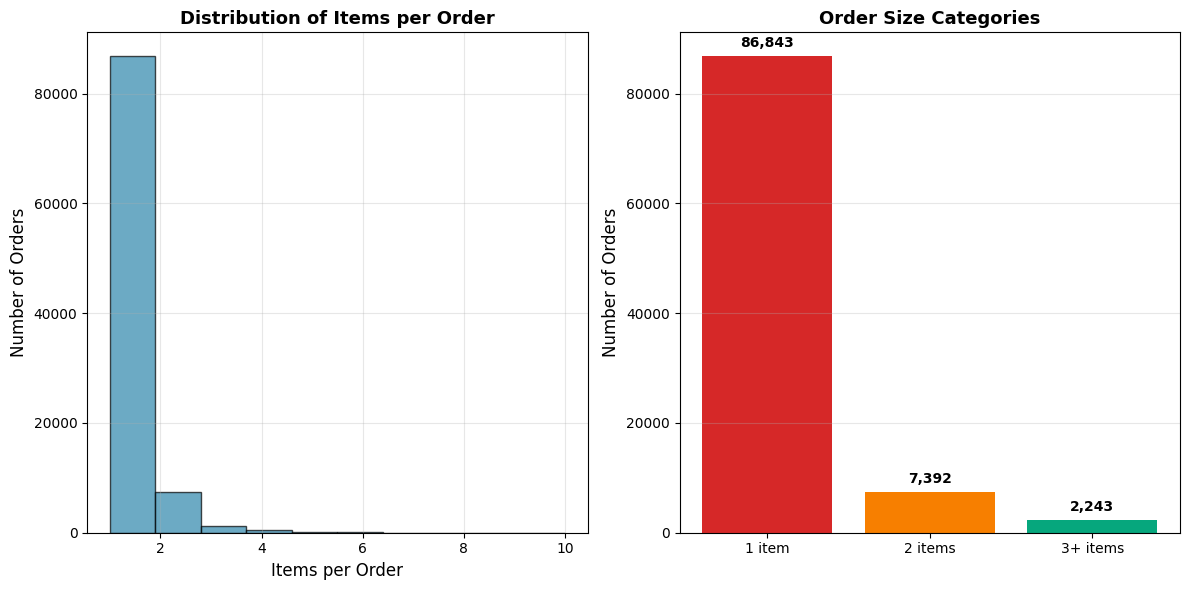


✅ Order composition visualization saved


In [6]:
# ============================================
# 4. ORDER-LEVEL ANALYSIS
# ============================================
print("\n4️⃣ Analyzing order composition...")

# Items per order
items_per_order = baskets.groupby('order_id').size()

print(f"\n📊 Order Statistics:")
print(f"   Total orders: {len(items_per_order):,}")
print(f"   Avg items per order: {items_per_order.mean():.2f}")
print(f"   Median items per order: {items_per_order.median():.0f}")
print(f"   Max items in order: {items_per_order.max()}")

# Distribution of items per order
print(f"\n📊 Items per Order Distribution:")
print(f"   1 item: {(items_per_order == 1).sum():,} orders ({(items_per_order == 1).sum()/len(items_per_order)*100:.1f}%)")
print(f"   2 items: {(items_per_order == 2).sum():,} orders ({(items_per_order == 2).sum()/len(items_per_order)*100:.1f}%)")
print(f"   3+ items: {(items_per_order >= 3).sum():,} orders ({(items_per_order >= 3).sum()/len(items_per_order)*100:.1f}%)")
print(f"   5+ items: {(items_per_order >= 5).sum():,} orders ({(items_per_order >= 5).sum()/len(items_per_order)*100:.1f}%)")

# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
items_per_order[items_per_order <= 10].hist(bins=10, edgecolor='black', alpha=0.7, color='#2E86AB')
plt.xlabel('Items per Order', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Distribution of Items per Order', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
order_size_summary = pd.DataFrame({
    'Order Size': ['1 item', '2 items', '3+ items'],
    'Count': [
        (items_per_order == 1).sum(),
        (items_per_order == 2).sum(),
        (items_per_order >= 3).sum()
    ]
})
plt.bar(order_size_summary['Order Size'], order_size_summary['Count'], color=['#D62828', '#F77F00', '#06A77D'])
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Order Size Categories', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(order_size_summary['Count']):
    plt.text(i, v + max(order_size_summary['Count'])*0.02, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('D:/Project/DataMining/ecommerce-customer-analytics/reports/figures/order_composition_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Order composition visualization saved")

* Mục đích: Xem trung bình mỗi đơn hàng có bao nhiêu sản phẩm → từ đó quyết định mức độ khả thi của Market Basket Analysis.
    * Tổng đơn hàng	- 96,478
    * Số sản phẩm trung bình/đơn - 1.14
    * Trung vị - 1
    * Đơn hàng có 1 sản phẩm - 86,843 (90%)
    * Đơn hàng có ≥2 sản phẩm - 9,635 (10%)
    * Tối đa - 21 sản phẩm
* Ý nghĩa:
* → 90% đơn hàng chỉ có 1 sản phẩm.
* → Điều này chứng tỏ khách hàng thường mua lẻ, không tạo giỏ hàng lớn.
* → Vì vậy, phân tích “sản phẩm đi kèm” (A → B) ở mức product_id sẽ không hiệu quả (data quá sparse).
* → Giải pháp khả thi: Phân tích ở mức danh mục (category-level) để tăng mật độ dữ liệu.

5. DECISION POINT

In [7]:
# ============================================
# 5. DECISION POINT
# ============================================
print("\n5️⃣ Market basket strategy decision...")

multi_item_orders = (items_per_order >= 2).sum()
multi_item_pct = multi_item_orders / len(items_per_order) * 100

print(f"\n📊 Multi-item Orders:")
print(f"   Orders with 2+ items: {multi_item_orders:,} ({multi_item_pct:.1f}%)")

if multi_item_pct < 20:
    print(f"\n   ⚠️  Low multi-item order rate (<20%)")
    print(f"   💡 Strategy: Category-level basket analysis")
    print(f"      - Analyze category combinations")
    print(f"      - More meaningful patterns")
    print(f"      - Better for sparse data")
    ANALYSIS_LEVEL = 'category'
else:
    print(f"\n   ✅ Sufficient multi-item orders (>20%)")
    print(f"   💡 Strategy: Product-level basket analysis")
    ANALYSIS_LEVEL = 'product'

print(f"\n🎯 Selected approach: {ANALYSIS_LEVEL.upper()}-level analysis")

print("\n" + "="*60)
print("✅ DATA PREPARATION COMPLETE")
print("="*60)
print(f"\n📊 Ready for Market Basket Analysis:")
print(f"   Analysis level: {ANALYSIS_LEVEL}")
print(f"   Multi-item orders: {multi_item_orders:,}")
print(f"   Categories: {baskets['category'].nunique()}")
print("="*60)


5️⃣ Market basket strategy decision...

📊 Multi-item Orders:
   Orders with 2+ items: 9,635 (10.0%)

   ⚠️  Low multi-item order rate (<20%)
   💡 Strategy: Category-level basket analysis
      - Analyze category combinations
      - More meaningful patterns
      - Better for sparse data

🎯 Selected approach: CATEGORY-level analysis

✅ DATA PREPARATION COMPLETE

📊 Ready for Market Basket Analysis:
   Analysis level: category
   Multi-item orders: 9,635
   Categories: 74


* Mục đích: Xác định chiến lược phân tích giỏ hàng hợp lý nhất dựa trên đặc trưng dữ liệu.
* Kết quả:
    * Đơn hàng có ≥2 sản phẩm: 9,635 (10%)
    * Multi-item order rate thấp hơn 20%
    * Chiến lược chọn: Category-level basket analysis
* Ý nghĩa chiến lược:
* → Dữ liệu E-commerce của bạn có giỏ hàng nhỏ, nên dùng category-level:
    * Tăng độ tin cậy của các luật kết hợp (association rules)
    * Giảm hiện tượng “data sparsity”
    * Kết quả phù hợp với phân tích cross-sell theo danh mục (vd. Health & Beauty → Personal Care)

* Insight Business:
* 90% khách hàng chỉ mua 1 sản phẩm/lần → cần chiến lược tăng giỏ hàng (basket size).
* 10% đơn hàng có 2+ sản phẩm → là phân khúc khách hàng có tiềm năng cross-sell cao.
    * Đề xuất combo khuyến mãi hợp lý (VD: Home Décor + Bed & Bath Table)
    * Thiết kế bố cục gian hàng gợi ý sản phẩm liên quan
    * Nâng cao tỷ lệ “Frequently Bought Together”

## CELL 2: CREATE TRANSACTION MATRIX (CATEGORY-LEVEL)

🔨 CREATING TRANSACTION MATRIX (CATEGORY-LEVEL)

1️⃣ Creating category-level transaction data...
   ✅ Total baskets: 96,478
   ✅ Multi-item baskets: 9,635
   ✅ Filtered out single-item orders: 86,843

2️⃣ Analyzing multi-item basket composition...

📊 Multi-item Basket Statistics:
   Mean categories per basket: 2.42
   Median: 2
   Max: 21

📊 Top 10 Categories in Multi-item Baskets:
    1. furniture_decor                - 3,223 baskets (33.5%)
    2. bed_bath_table                 - 3,117 baskets (32.4%)
    3. computers_accessories          - 1,894 baskets (19.7%)
    4. housewares                     - 1,808 baskets (18.8%)
    5. sports_leisure                 - 1,659 baskets (17.2%)
    6. health_beauty                  - 1,489 baskets (15.5%)
    7. garden_tools                   - 1,415 baskets (14.7%)
    8. watches_gifts                  - 665 baskets (6.9%)
    9. office_furniture               - 652 baskets (6.8%)
   10. telephony                      - 620 baskets (6.4%)

3️⃣ 

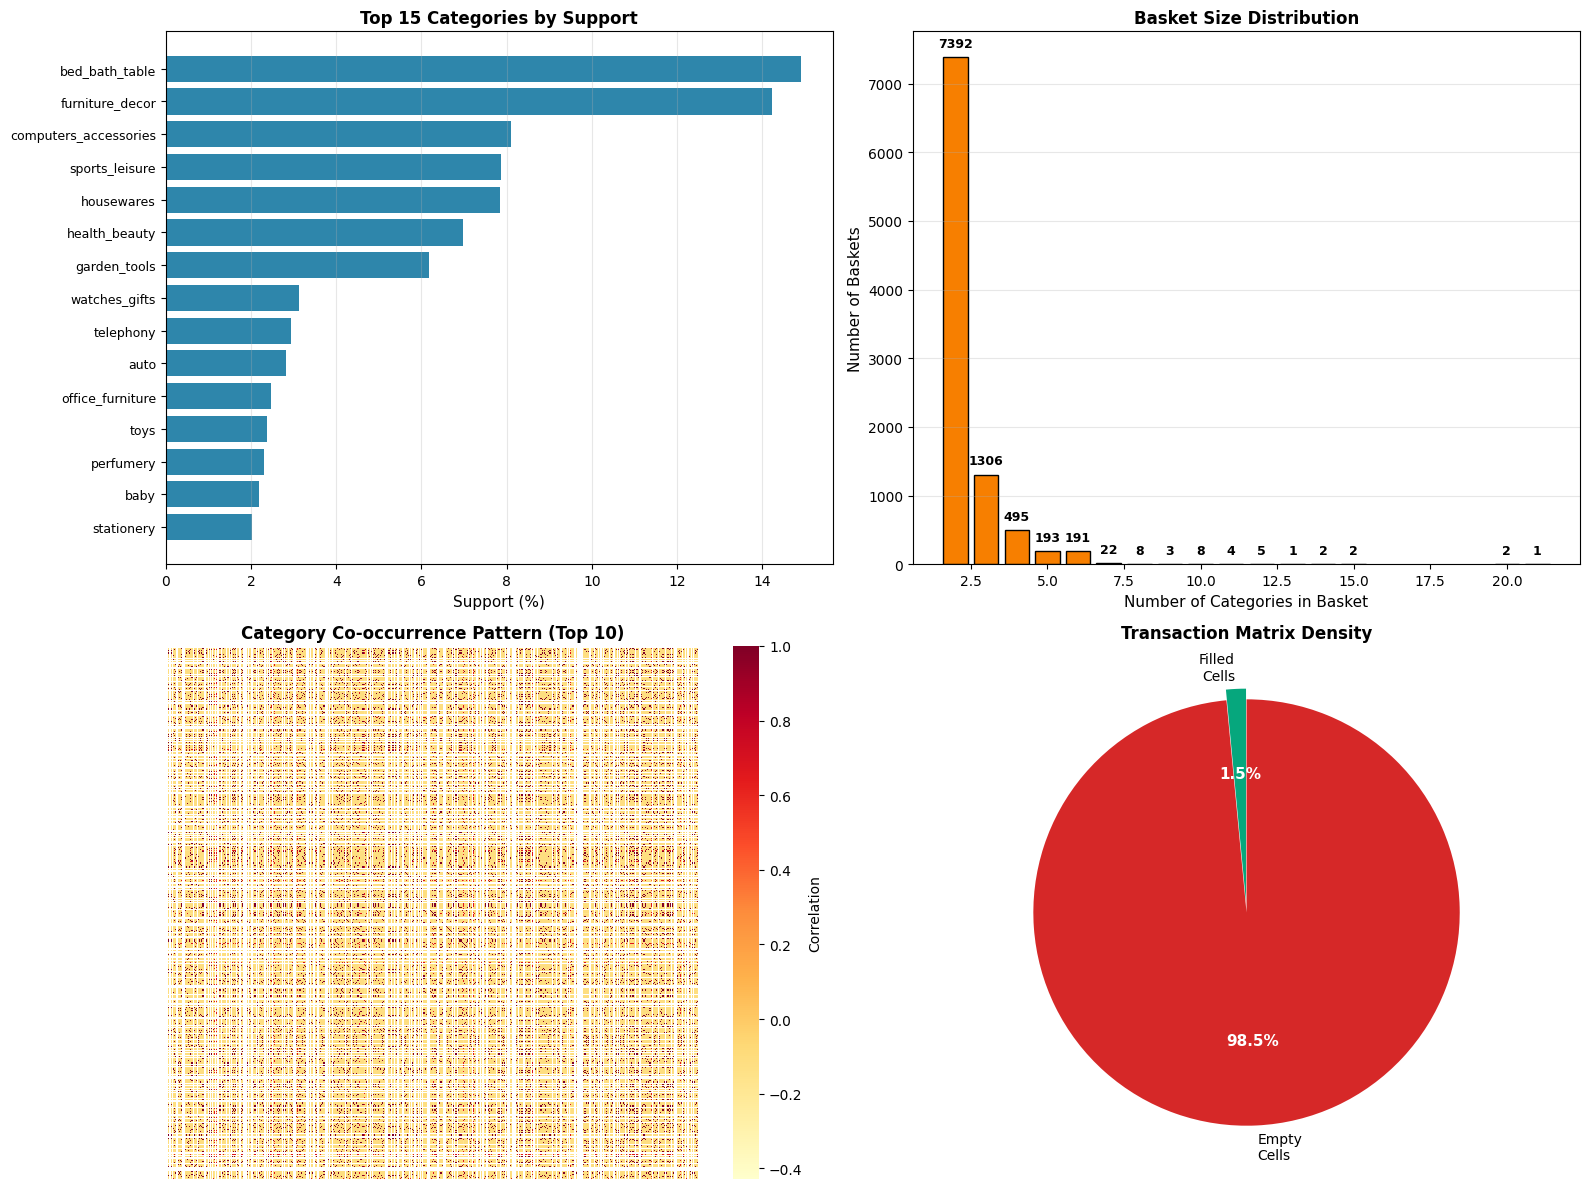

   ✅ Transaction analysis visualization saved

6️⃣ Saving transaction matrix...
   ✅ Basket matrix saved: basket_matrix.csv

✅ TRANSACTION MATRIX READY

📊 Matrix Summary:
   Transactions: 9,635
   Categories: 72
   Sparsity: 98.50%
   Avg categories/basket: 2.42

🎯 Ready for Apriori Algorithm:
   Min support threshold: 0.01 (1%)
   Min confidence threshold: 0.10 (10%)
   Expected: 50-200 association rules


In [8]:
print("="*60)
print("🔨 CREATING TRANSACTION MATRIX (CATEGORY-LEVEL)")
print("="*60)

# ============================================
# 1. CREATE CATEGORY-LEVEL BASKETS
# ============================================
print("\n1️⃣ Creating category-level transaction data...")

# Group by order_id and collect categories
category_baskets = baskets.groupby('order_id')['category'].apply(list).reset_index()
category_baskets.columns = ['order_id', 'categories']

print(f"   ✅ Total baskets: {len(category_baskets):,}")

# Filter to multi-item orders only
category_baskets['num_items'] = category_baskets['categories'].apply(len)
multi_item_baskets = category_baskets[category_baskets['num_items'] >= 2].copy()

print(f"   ✅ Multi-item baskets: {len(multi_item_baskets):,}")
print(f"   ✅ Filtered out single-item orders: {len(category_baskets) - len(multi_item_baskets):,}")

# ============================================
# 2. ANALYZE BASKET COMPOSITION
# ============================================
print("\n2️⃣ Analyzing multi-item basket composition...")

print(f"\n📊 Multi-item Basket Statistics:")
print(f"   Mean categories per basket: {multi_item_baskets['num_items'].mean():.2f}")
print(f"   Median: {multi_item_baskets['num_items'].median():.0f}")
print(f"   Max: {multi_item_baskets['num_items'].max()}")

# Top category combinations
all_categories_in_baskets = []
for cats in multi_item_baskets['categories']:
    all_categories_in_baskets.extend(cats)

category_freq = pd.Series(all_categories_in_baskets).value_counts()

print(f"\n📊 Top 10 Categories in Multi-item Baskets:")
for i, (cat, count) in enumerate(category_freq.head(10).items(), 1):
    pct = count / len(multi_item_baskets) * 100
    print(f"   {i:2d}. {cat:30s} - {count:,} baskets ({pct:.1f}%)")

# ============================================
# 3. CREATE BINARY TRANSACTION MATRIX
# ============================================
print("\n3️⃣ Creating binary transaction matrix...")
print("   ⏳ Encoding transactions...")

# Use TransactionEncoder from mlxtend
te = TransactionEncoder()
te_array = te.fit(multi_item_baskets['categories']).transform(multi_item_baskets['categories'])

# Convert to DataFrame
basket_matrix = pd.DataFrame(te_array, columns=te.columns_)

print(f"   ✅ Matrix created!")
print(f"   ✅ Shape: {basket_matrix.shape}")
print(f"      Transactions (rows): {basket_matrix.shape[0]:,}")
print(f"      Categories (columns): {basket_matrix.shape[1]}")

# ============================================
# 4. MATRIX ANALYSIS
# ============================================
print("\n4️⃣ Transaction matrix analysis...")

# Sparsity
total_cells = basket_matrix.shape[0] * basket_matrix.shape[1]
filled_cells = basket_matrix.sum().sum()
sparsity = (1 - filled_cells / total_cells) * 100

print(f"\n📊 Matrix Statistics:")
print(f"   Total cells: {total_cells:,}")
print(f"   Filled cells: {int(filled_cells):,}")
print(f"   Sparsity: {sparsity:.2f}%")
print(f"   Density: {100-sparsity:.2f}%")

# Category support (how often each category appears)
category_support = basket_matrix.mean().sort_values(ascending=False)

print(f"\n📊 Top 10 Category Support (% of baskets):")
for i, (cat, support) in enumerate(category_support.head(10).items(), 1):
    print(f"   {i:2d}. {cat:30s} - {support*100:.2f}%")

# ============================================
# 5. VISUALIZATION
# ============================================
print("\n5️⃣ Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top categories by support
ax1 = axes[0, 0]
top_15_support = category_support.head(15)
ax1.barh(range(len(top_15_support)), top_15_support.values * 100, color='#2E86AB')
ax1.set_yticks(range(len(top_15_support)))
ax1.set_yticklabels(top_15_support.index, fontsize=9)
ax1.set_xlabel('Support (%)', fontsize=11)
ax1.set_title('Top 15 Categories by Support', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Basket size distribution
ax2 = axes[0, 1]
basket_size_dist = multi_item_baskets['num_items'].value_counts().sort_index()
ax2.bar(basket_size_dist.index, basket_size_dist.values, color='#F77F00', edgecolor='black')
ax2.set_xlabel('Number of Categories in Basket', fontsize=11)
ax2.set_ylabel('Number of Baskets', fontsize=11)
ax2.set_title('Basket Size Distribution', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(basket_size_dist.values):
    ax2.text(basket_size_dist.index[i], v + max(basket_size_dist.values)*0.02, 
             str(v), ha='center', fontweight='bold', fontsize=9)

# Plot 3: Category co-occurrence heatmap (top 10)
ax3 = axes[1, 0]
top_10_cats = category_support.head(10).index
top_10_matrix = basket_matrix[top_10_cats]
correlation = top_10_matrix.T.corr()

sns.heatmap(correlation, annot=False, cmap='YlOrRd', ax=ax3, 
            xticklabels=False, yticklabels=False, cbar_kws={'label': 'Correlation'})
ax3.set_title('Category Co-occurrence Pattern (Top 10)', fontsize=12, fontweight='bold')

# Plot 4: Matrix sparsity
ax4 = axes[1, 1]
metrics = ['Filled\nCells', 'Empty\nCells']
values = [100-sparsity, sparsity]
colors = ['#06A77D', '#D62828']
wedges, texts, autotexts = ax4.pie(values, labels=metrics, autopct='%1.1f%%', 
                                     colors=colors, startangle=90, explode=(0.05, 0))
ax4.set_title('Transaction Matrix Density', fontsize=12, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.savefig('D:/Project/DataMining/ecommerce-customer-analytics/reports/figures/market_basket_transaction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Transaction analysis visualization saved")

# ============================================
# 6. SAVE TRANSACTION MATRIX
# ============================================
print("\n6️⃣ Saving transaction matrix...")

basket_matrix.to_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/processed/basket_matrix.csv', index=False)
print(f"   ✅ Basket matrix saved: basket_matrix.csv")

# ============================================
# 7. SUMMARY
# ============================================
print("\n" + "="*60)
print("✅ TRANSACTION MATRIX READY")
print("="*60)
print(f"\n📊 Matrix Summary:")
print(f"   Transactions: {basket_matrix.shape[0]:,}")
print(f"   Categories: {basket_matrix.shape[1]}")
print(f"   Sparsity: {sparsity:.2f}%")
print(f"   Avg categories/basket: {multi_item_baskets['num_items'].mean():.2f}")

print(f"\n🎯 Ready for Apriori Algorithm:")
print(f"   Min support threshold: 0.01 (1%)")
print(f"   Min confidence threshold: 0.10 (10%)")
print(f"   Expected: 50-200 association rules")

print("="*60)